# Tomato Leaf Disease Classification

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [10]:
img_height, img_width = 256, 256  # Maintain original resolution
batch_size = 32
num_classes = 10

In [11]:
train_dir = 'dataset/train'
val_dir = 'dataset/val'

In [12]:
# Efficient Data Loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

#training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'  # Use categorical labels
).map(preprocess).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

#validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'  # Use categorical labels
).map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [13]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)       

In [14]:
# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1)
]


history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 1.8397 - accuracy: 0.3111
Epoch 1: val_loss improved from inf to 1.55944, saving model to best_model.keras
313/313 [==============================] - 165s 405ms/step - loss: 1.8397 - accuracy: 0.3111 - val_loss: 1.5594 - val_accuracy: 0.4140
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 1.2814 - accuracy: 0.5396
Epoch 2: val_loss improved from 1.55944 to 1.10837, saving model to best_model.keras
313/313 [==============================] - 125s 398ms/step - loss: 1.2814 - accuracy: 0.5396 - val_loss: 1.1084 - val_accuracy: 0.5930
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.6321
Epoch 3: val_loss improved from 1.10837 to 0.95915, saving model to best_model.keras
313/313 [==============================] - 1221s 4s/step - loss: 1.0303 - accuracy: 0.6321 - val_loss: 0.9592 - val_accuracy: 0.6430
Epoch 4/50
313/313 [==============================] - ETA:

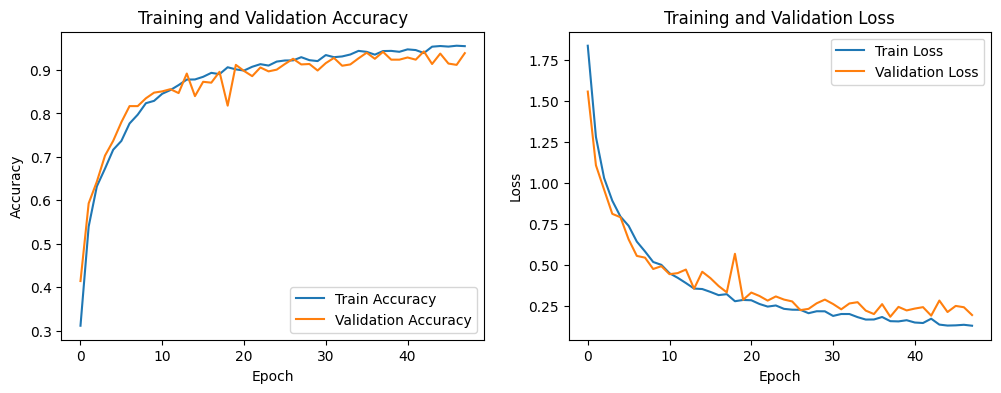

1/1 [==============================] - 1s 605ms/step


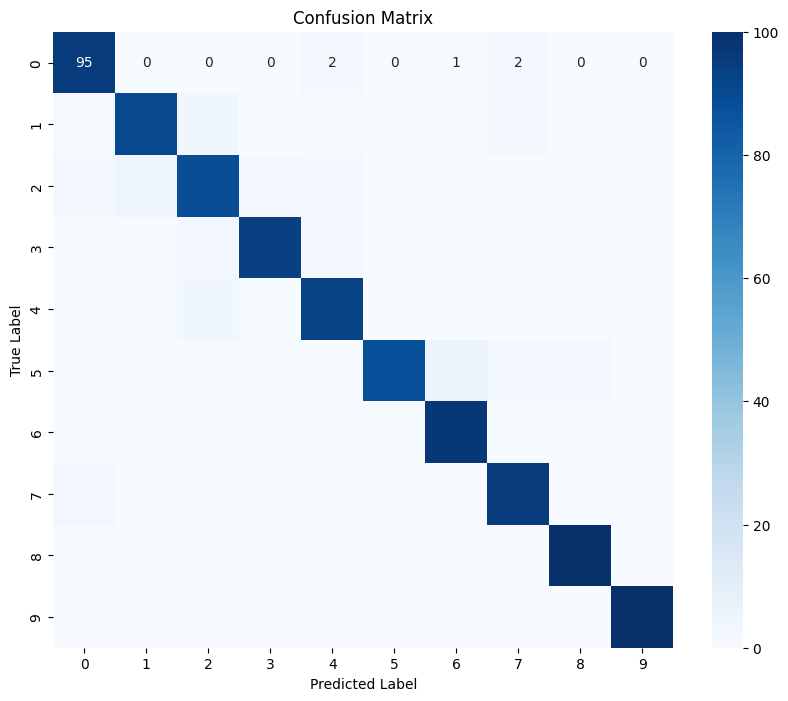

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming history is your training history object
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('training_validation_accuracy.png')  # Save the accuracy plot

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('training_validation_loss.png')  # Save the loss plot

plt.show()

# Confusion Matrix
val_labels = []
val_preds = []

for images, labels in val_dataset:
    val_labels.extend(np.argmax(labels.numpy(), axis=1))
    val_preds.extend(np.argmax(model.predict(images), axis=1))

conf_matrix = confusion_matrix(val_labels, val_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the confusion matrix plot

plt.show()

In [17]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Evaluate on validation dataset
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation accuracy: {val_acc:.2f}")

# Get the true labels and predictions
val_labels = []
val_predictions = []

for images, labels in val_dataset:
    preds = model.predict(images)
    val_predictions.extend(np.argmax(preds, axis=1))
    val_labels.extend(np.argmax(labels.numpy(), axis=1))

# Compute precision, recall, and F1 score
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')

print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")
print(f"Validation F1 score: {val_f1:.2f}")

32/32 [==============================] - 4s 117ms/step - loss: 0.1824 - accuracy: 0.9420
Validation accuracy: 0.94
1/1 [==============================] - 0s 80ms/step
Validation Precision: 0.94
Validation Recall: 0.94
Validation F1 score: 0.94


In [19]:
model.save('light_tomato.h5')

C:\Users\parik\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import os
import random
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('light_tomato.h5')

# Path to the validation directory
val_dir = 'dataset/val'

# Get list of disease folders
disease_folders = os.listdir(val_dir)

# Class names
class_names = {
    0: 'bacterial spot',
    1: 'early blight',
    2: 'late blight',
    3: 'leaf mold',
    4: 'Septoria',
    5: 'spider mites',
    6: 'target spot',
    7: 'yellow leaf',
    8: 'mosaic',
    9: 'healthy'
}

# Iterate 10 times
for _ in range(10):
    print(f"Iteration {_ + 1}:")
    # Choose a random disease folder
    random_folder_name = random.choice(disease_folders)
    # Get list of images in the random disease folder
    images = os.listdir(os.path.join(val_dir, random_folder_name))
    # Choose a random image from the folder
    random_image = random.choice(images)
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(val_dir, random_folder_name, random_image),
        target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = img_array / 255.0  # Normalize
    # Predict disease label using the model
    predictions = model.predict(img_array)
    predicted_label = predictions.argmax(axis=-1)[0]
    # Update class_names dictionary if predicted_label is not in the dictionary
    if predicted_label not in class_names:
        class_names[predicted_label] = f'Class {predicted_label}'
    # Get the class name from the folder name
    actual_label = random_folder_name.split('___')[-1]
    # Print the predicted label and actual label
    print(f"Predicted: {class_names[predicted_label]}, Actual: {actual_label}")
    print()

Iteration 1:
1/1 [==============================] - 0s 320ms/step
Predicted: healthy, Actual: healthy

Iteration 2:
1/1 [==============================] - 0s 81ms/step
Predicted: spider mites, Actual: Spider_mites Two-spotted_spider_mite

Iteration 3:
1/1 [==============================] - 0s 54ms/step
Predicted: healthy, Actual: healthy

Iteration 4:
1/1 [==============================] - 0s 74ms/step
Predicted: Septoria, Actual: Septoria_leaf_spot

Iteration 5:
1/1 [==============================] - 0s 62ms/step
Predicted: early blight, Actual: Early_blight

Iteration 6:
1/1 [==============================] - 0s 72ms/step
Predicted: spider mites, Actual: Spider_mites Two-spotted_spider_mite

Iteration 7:
1/1 [==============================] - 0s 65ms/step
Predicted: target spot, Actual: Target_Spot

Iteration 8:
1/1 [==============================] - 0s 58ms/step
Predicted: Septoria, Actual: Septoria_leaf_spot

Iteration 9:
1/1 [==============================] - 0s 55ms/step
Predicte